In [13]:
import torch
from transformers import PreTrainedModel, AutoTokenizer
from typing import List, Dict, Set, Tuple, Optional
from tqdm import tqdm
import numpy as np
import json
import matplotlib.pyplot as plt
from collections import defaultdict

def load_models_and_tokenizer(target_paths: List[str], reference_path: str) -> Tuple[List[PreTrainedModel], PreTrainedModel, AutoTokenizer]:
    from omegaconf import OmegaConf
    from llm_unlearning.models.models import load_model_and_tokenizer

    # Load reference model and tokenizer
    config_reference = OmegaConf.create({"path": reference_path, "tokenizer_path": "microsoft/phi-1_5", "fp16": True})
    reference_model, tokenizer = load_model_and_tokenizer(config_reference)
    reference_model = reference_model.to('cuda' if torch.cuda.is_available() else 'cpu')

    # Load target models
    target_models = []
    for path in target_paths:
        config_target = OmegaConf.create({"path": path, "tokenizer_path": "microsoft/phi-1_5", "fp16": True})
        target_model, _ = load_model_and_tokenizer(config_target)
        target_model = target_model.to('cuda' if torch.cuda.is_available() else 'cpu')
        target_models.append(target_model)

    return target_models, reference_model, tokenizer

def load_tofu_dataset(tokenizer: AutoTokenizer):
    from omegaconf import OmegaConf
    from llm_unlearning.unlearning_datasets.tofu import TofuDataset

    config = OmegaConf.create({
        "split": "full",
        "max_length": 512,
        "question_key": "question",
        "answer_key": "answer",
        "question_start_tag": "Question: ",
        "question_end_tag": "\nAnswer: ",
        "answer_tag": ""
    })
    return TofuDataset(tokenizer, config)

def extract_question_tokens(sample: Dict, pad_token_id: int) -> Tuple[torch.Tensor, torch.Tensor]:
    from llm_unlearning.evals.utils import extract_question_tokens
    return extract_question_tokens(sample, pad_token_id)

def extract_answer_tokens(input_ids: torch.Tensor, question_length: torch.Tensor, pad_token_id: int) -> torch.Tensor:
    from llm_unlearning.evals.utils import extract_answer_tokens
    return extract_answer_tokens(input_ids, question_length, pad_token_id)

def compute_token_logprobs(model: PreTrainedModel, input_ids: torch.Tensor, attention_mask: torch.Tensor) -> Dict[int, torch.Tensor]:
    device = next(model.parameters()).device
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

    log_probs = torch.log_softmax(logits, dim=-1)
    token_log_probs = {}
    for pos in range(input_ids.shape[1] - 1):
        next_token = input_ids[0, pos + 1].item()
        token_log_probs[pos] = log_probs[0, pos, next_token].item()

    return token_log_probs

def analyze_token_pressure(dataset, target_models, reference_model, tokenizer,
                         num_samples: int = 400, take_from_back: bool = True) -> Dict:
    results = {
        'token_positions': defaultdict(list),
        'logprob_diffs': defaultdict(list),
        'tokens': defaultdict(list)
    }

    samples = range(len(dataset)-num_samples, len(dataset)) if take_from_back else range(num_samples)

    for idx in tqdm(samples, desc="Analyzing token pressure"):
        sample = dataset[idx]
        for key in sample:
            if isinstance(sample[key], torch.Tensor):
                sample[key] = sample[key].unsqueeze(0)

        question_length = sample["question_length"].item()

        # Get log probabilities for each model
        ref_logprobs = compute_token_logprobs(reference_model, sample["input_ids"], sample["attention_mask"])
        target_logprobs_list = [compute_token_logprobs(model, sample["input_ids"], sample["attention_mask"])
                               for model in target_models]

        # Analyze answer tokens
        for pos in range(question_length, len(sample["input_ids"][0])-1):
            token = sample["input_ids"][0, pos + 1].item()
            if token == tokenizer.eos_token_id:
                continue

            relative_pos = pos - question_length
            token_str = tokenizer.decode([token])

            # Compute differences for each target model
            for model_idx, target_logprobs in enumerate(target_logprobs_list):
                logprob_diff = ref_logprobs[pos] - target_logprobs[pos]

                results['token_positions'][model_idx].append(relative_pos)
                results['logprob_diffs'][model_idx].append(logprob_diff)
                results['tokens'][model_idx].append(token_str)

    return results

def plot_token_pressure_analysis(results: Dict, temperatures: List[float], window_size: int = 10, cutoff_ratio: float = 0.1) -> plt.Figure:
    plt.figure(figsize=(12, 6))
    from collections import Counter

    for model_idx in results['token_positions'].keys():
        positions = np.array(results['token_positions'][model_idx])
        diffs = np.array(results['logprob_diffs'][model_idx])

        maximum_count = Counter(positions).most_common(1)[0][1]
        cutoff = maximum_count * cutoff_ratio

        # Calculate moving averages
        unique_positions = sorted(x for x in set(positions) if positions.tolist().count(x) > cutoff)
        avg_diffs = []
        for pos in unique_positions:
            mask = (positions >= pos - window_size/2) & (positions <= pos + window_size/2)
            avg_diffs.append(np.mean(diffs[mask]))

        plt.plot(unique_positions, avg_diffs, label=f'T={temperatures[model_idx]}', alpha=0.7)

    plt.xlabel('Token Position (relative to answer start)')
    plt.ylabel('Average Log Probability Difference (Reference - Target)')
    plt.title('Token Pressure by Position')
    plt.grid(True, alpha=0.3)
    plt.legend()
    return plt.gcf()

In [23]:
# Load models and data
reference_path = "locuslab/tofu_ft_phi-1.5"
target_paths = [
    # "/nfs/homedirs/gudm/development/new/results/sweep_temperature/unlearn10_gd_1.0_2024-11-25_02-47-01_123/checkpoint-240",
    # "/nfs/homedirs/gudm/development/new/results/sweep_temperature/unlearn10_gd_1.1_2024-11-25_02-47-01_123/checkpoint-240",
    # "/nfs/homedirs/gudm/development/new/results/sweep_temperature/unlearn10_gd_1.2_2024-11-25_02-47-01_123/checkpoint-240",
    "/nfs/homedirs/gudm/development/new/results/sweep_temperature/unlearn10_gd_1.3_2024-11-25_02-47-01_123/checkpoint-240",
    # "/nfs/homedirs/gudm/development/new/results/sweep_temperature/unlearn10_gd_1.4_2024-11-25_02-47-01_123/checkpoint-240",
    "/nfs/homedirs/gudm/development/new/results/sweep_temperature/unlearn10_gd_1.5_2024-11-25_02-47-01_123/checkpoint-240"
]

target_models, reference_model, tokenizer = load_models_and_tokenizer(target_paths, reference_path)
dataset = load_tofu_dataset(tokenizer)
results = analyze_token_pressure(dataset, target_models, reference_model, tokenizer)

Loading model from Hugging Face Hub: locuslab/tofu_ft_phi-1.5
Loading tokenizer from Hugging Face Hub: microsoft/phi-1_5
Loading model from local checkpoint: /nfs/homedirs/gudm/development/new/results/sweep_temperature/unlearn10_gd_1.3_2024-11-25_02-47-01_123/checkpoint-240


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading tokenizer from Hugging Face Hub: microsoft/phi-1_5
Loading model from local checkpoint: /nfs/homedirs/gudm/development/new/results/sweep_temperature/unlearn10_gd_1.5_2024-11-25_02-47-01_123/checkpoint-240


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading tokenizer from Hugging Face Hub: microsoft/phi-1_5


Analyzing token pressure: 100%|██████████| 400/400 [00:37<00:00, 10.69it/s]


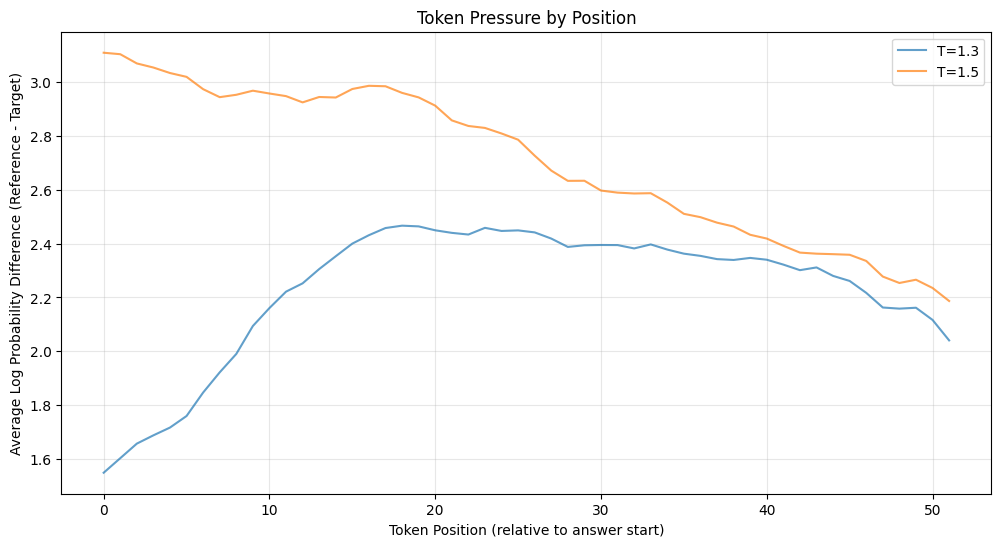

In [24]:
# Plot results
temperatures = [1.3, 1.5]
fig = plot_token_pressure_analysis(results, temperatures, cutoff_ratio=0.1)
plt.show()

# Save results
output_data = {
    'positions': {str(k): v for k, v in results['token_positions'].items()},
    'diffs': {str(k): v for k, v in results['logprob_diffs'].items()},
    'tokens': {str(k): v for k, v in results['tokens'].items()},
    'temperatures': temperatures
}

with open('token_pressure_results.json', 'w') as f:
    json.dump(output_data, f)